# Dataset description

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars. The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute.

In [1]:
## Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math
from scipy.stats import norm, skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
cols = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']

In [3]:
# Importing dataset from UCI Machine Learning Repository
df = pd.read_csv('./data/imports-85.data', names=cols)

# Seeing the first 5 rows
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
df.shape 

(205, 26)

In [5]:
id = np.array(range(0,205))
df = df.assign(ID=id)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,ID
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495,0
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500,1
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500,2
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950,3
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450,4


# Data Visualization, Preprocessing and Cleaning

# # Finding and removing missing values

In [6]:
# Seeing dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [7]:
# Seeing columns
df.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,ID
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220,102.000000
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443,59.322565
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000,0.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000,51.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000,102.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000,153.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000,204.000000


In [8]:
# Looking for total missing values in each column
df.isna().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
ID                   0
dtype: int64

In [9]:
# Replace missign values with numpy NaN values and drop the corresponding observations
df.replace('?',np.nan, inplace=True)

In [10]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,ID
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495,0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500,1
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500,2
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950,3
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450,4


In [11]:
df.dropna(inplace=True)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,ID
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950,3
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450,4
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,...,mpfi,3.19,3.40,8.5,110,5500,19,25,17710,6
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,...,mpfi,3.13,3.40,8.3,140,5500,17,20,23875,8
10,2,192,bmw,gas,std,two,sedan,rwd,front,101.2,...,mpfi,3.50,2.80,8.8,101,5800,23,29,16430,10


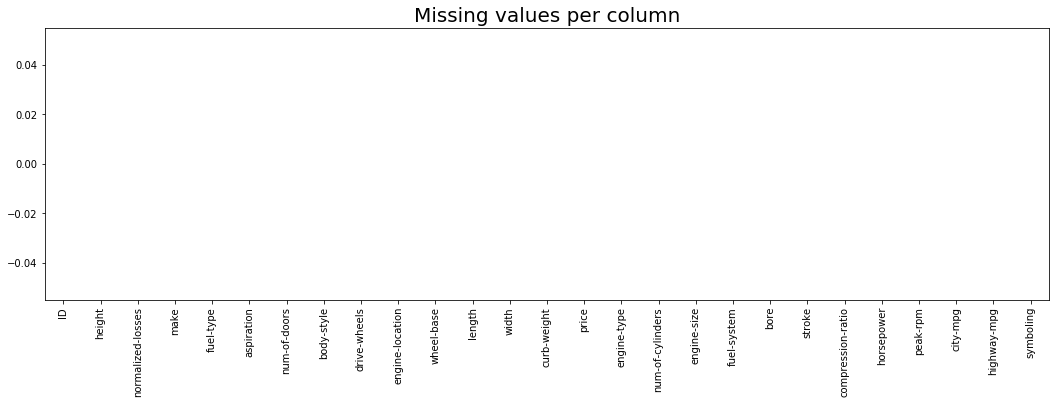

In [12]:
# Checking if we still have any missing values
plt.subplots(0,0, figsize = (18,5))
ax = (df.isnull().sum()).sort_values(ascending = False).plot.bar(color = 'blue')
plt.title('Missing values per column', fontsize = 20);

# # Target Analysis

In [13]:
# Our target column is the nosmalized losses column
print(df['normalized-losses'].describe())

count     159
unique     51
top       161
freq       11
Name: normalized-losses, dtype: object


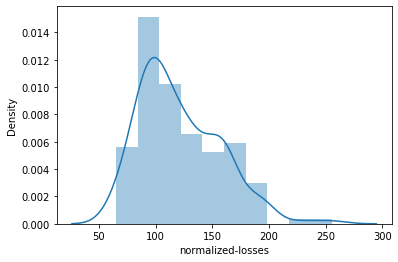

In [14]:
 sns.distplot(df['normalized-losses'])

In [15]:
print("Skewness: %f" % df['normalized-losses'].skew())
print("Kurtosis: %f" % df['normalized-losses'].kurt())

Skewness: 0.835766
Kurtosis: 0.623170


In [16]:
df["normalized-losses"] = pd.to_numeric(df["normalized-losses"])

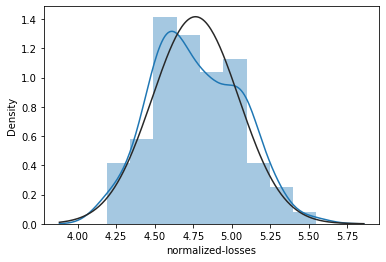

In [17]:
# fixing the skew

df['normalized-losses'] = np.log1p(df['normalized-losses'])
sns.distplot(df['normalized-losses'], fit=norm);

# # Exploratory Analysis

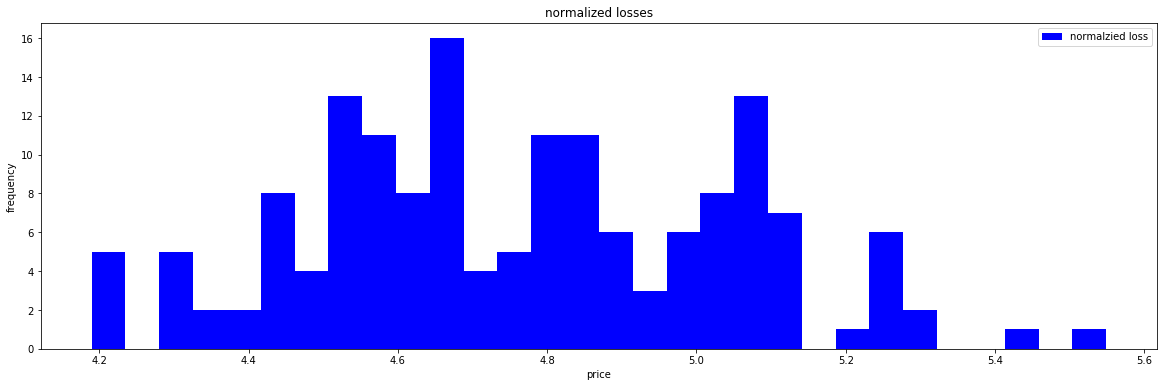

In [18]:
# Plotting a histogram of our ftarget feature normalzied-losses
plt.figure(figsize=(20,6)) # creating the figure
plt.hist(df['normalized-losses'] # plotting the histogram
         ,bins=30 # defyning number of bars
         ,label='normalzied loss' # add legend
        ,color='blue') # defyning the color

plt.xlabel('price') # add xlabel
plt.ylabel('frequency') # add ylabel
plt.legend()
plt.title('normalized losses');

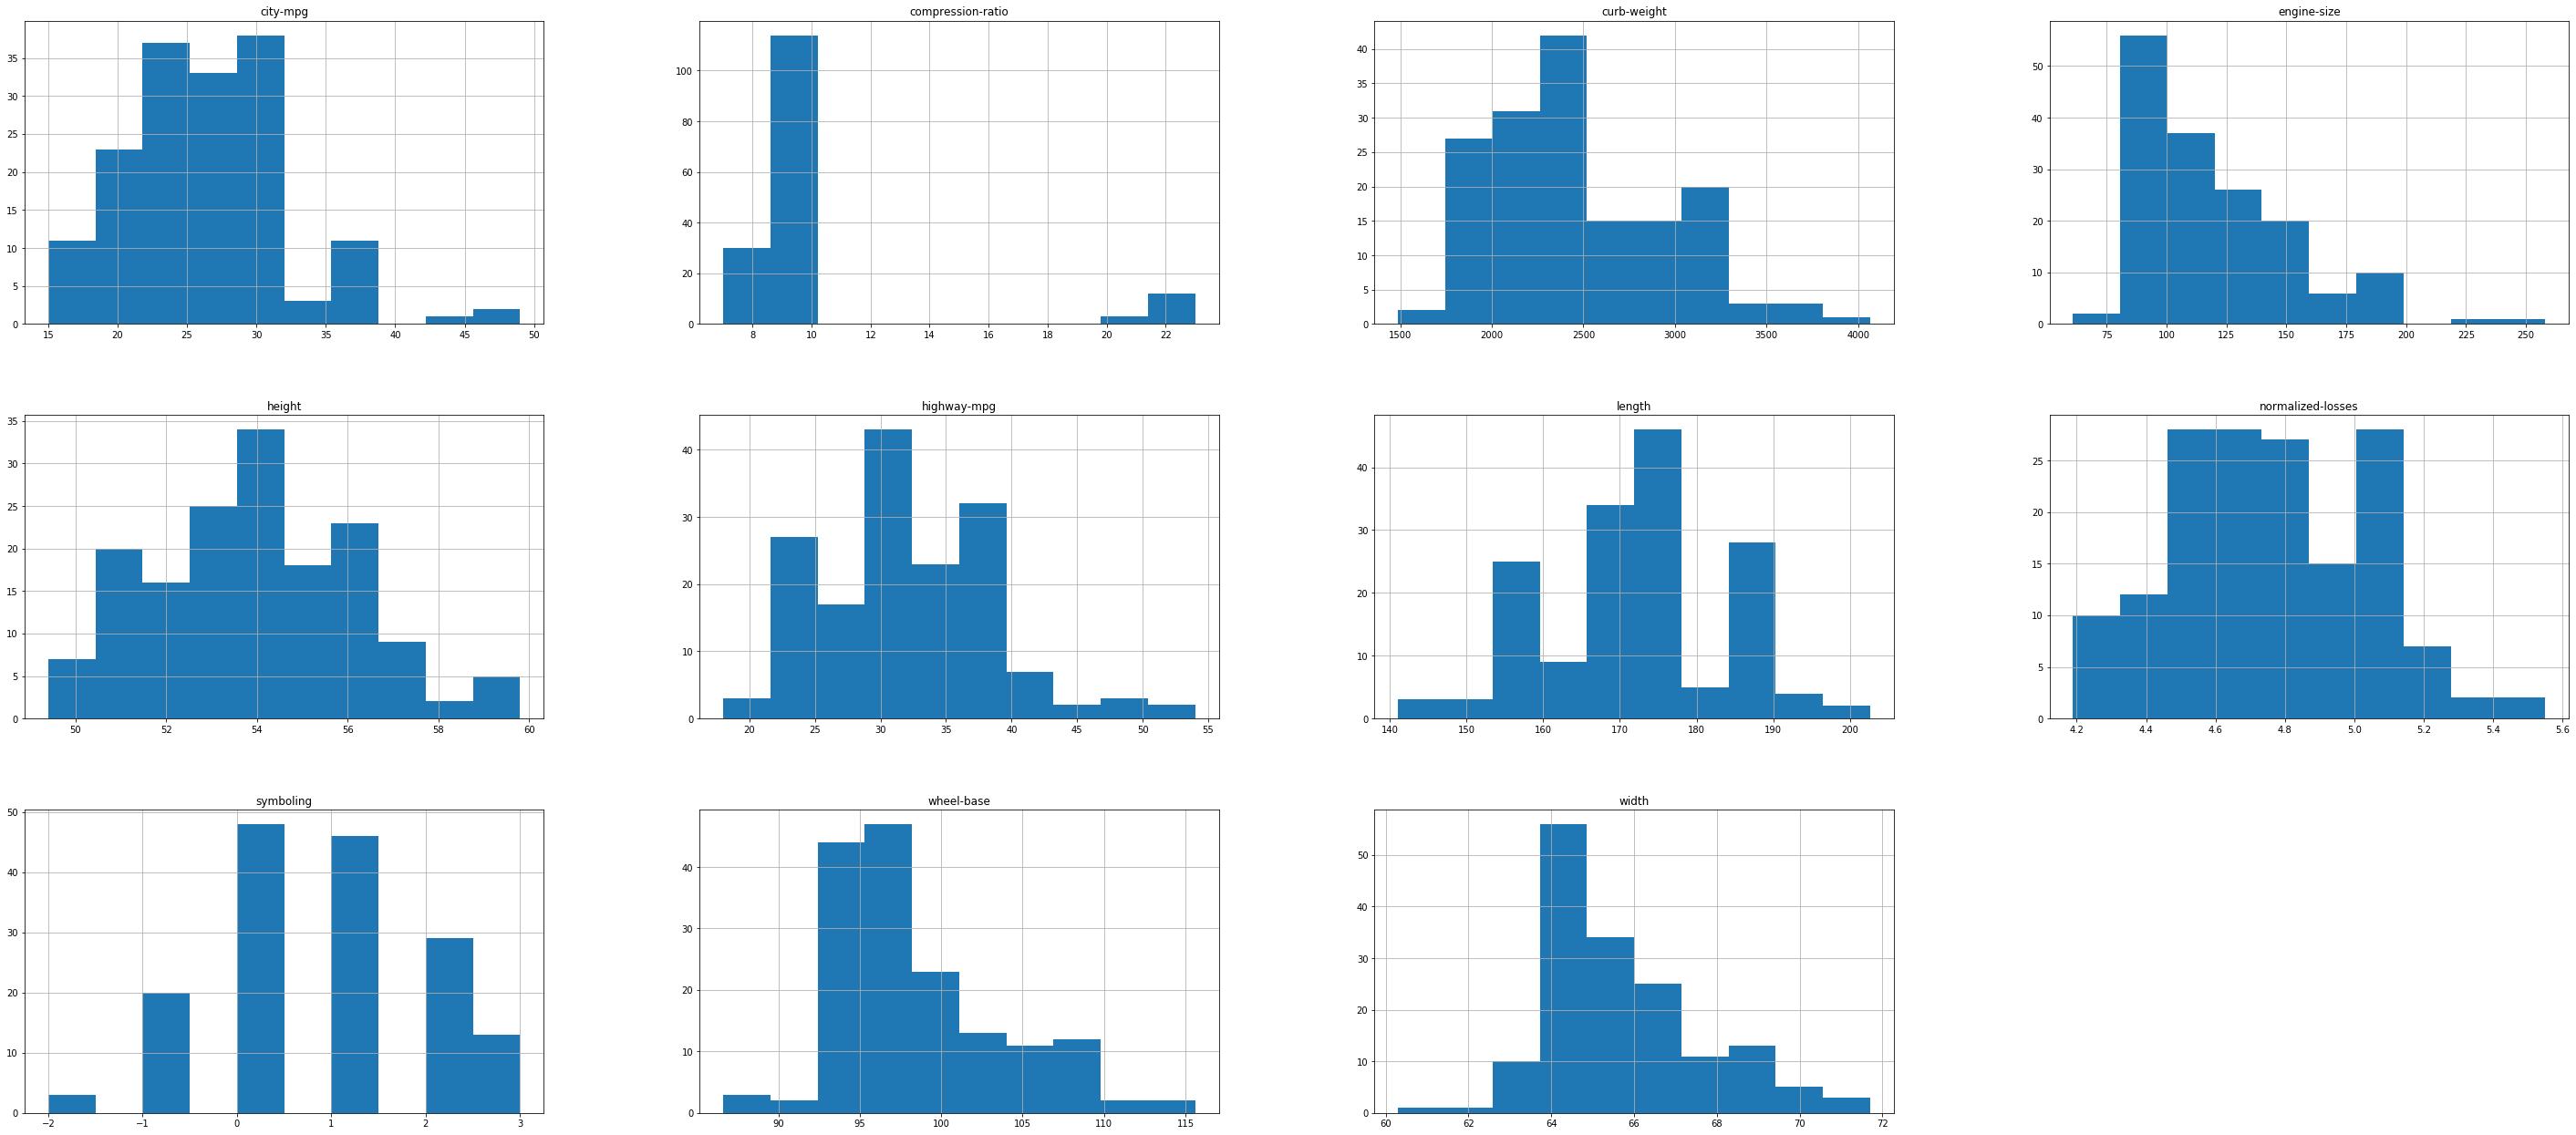

In [19]:
# Saving numerical features
num_var = ['symboling','normalized-losses','wheel-base','length'
          ,'width','height','curb-weight','engine-size','bore'
           ,'stroke','compression-ratio','horsepower','peak-rpm'
           ,'city-mpg','highway-mpg']

# plotting a histogram for each feature
df[num_var].hist(bins=10
                   , figsize=(50,30)
                   , layout=(4,4));

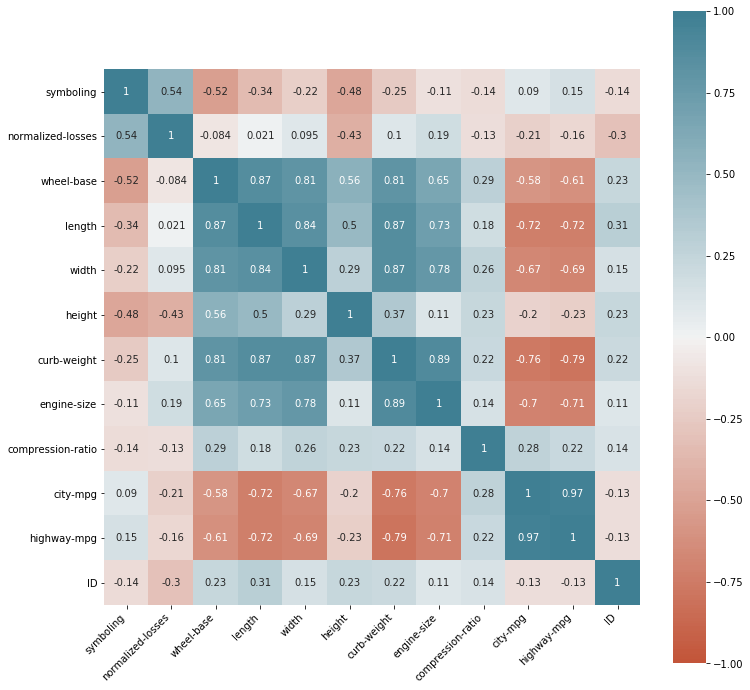

In [20]:
# Numerical variables correlation
corr = df.corr() # creting the correlation matrix

plt.figure(figsize=(12,12)) # creating the and difyning figure size
ax = sns.heatmap( # plotting correlation matrix
    corr,vmin=-1, vmax=1, center=0,
    annot=True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels( # adding axes values
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


Symboling, and engine-size have highest correlation with normalized loss

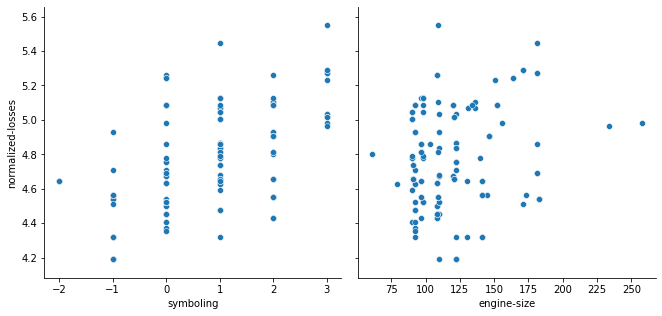

In [21]:
# # Plotting a scatter plot of relation between engine_size, symboling and normalzied-losses
g = sns.pairplot(data=df,
                  y_vars=['normalized-losses'],
                  x_vars=['symboling', 'engine-size'])
g.fig.set_size_inches(10,5)

Let's make a bivariate a analysis of each categorical feature with our target to understand better this features¶

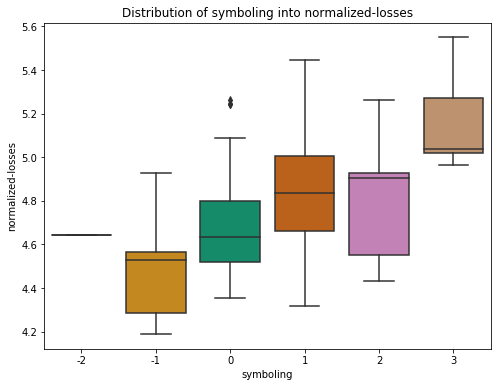

In [22]:
# Plotting Distribution of symboling into normalized-losses
plt.figure(figsize=(8,6))
sns.boxplot(x='symboling',y='normalized-losses',data=df, 
                 palette="colorblind")
plt.title('Distribution of symboling into normalized-losses');

As mentioned in the data set description, the cars with high symboling are more risky. These risky cars also show high normalized-loss values. The higher the risk, the higher the normalized-loss.

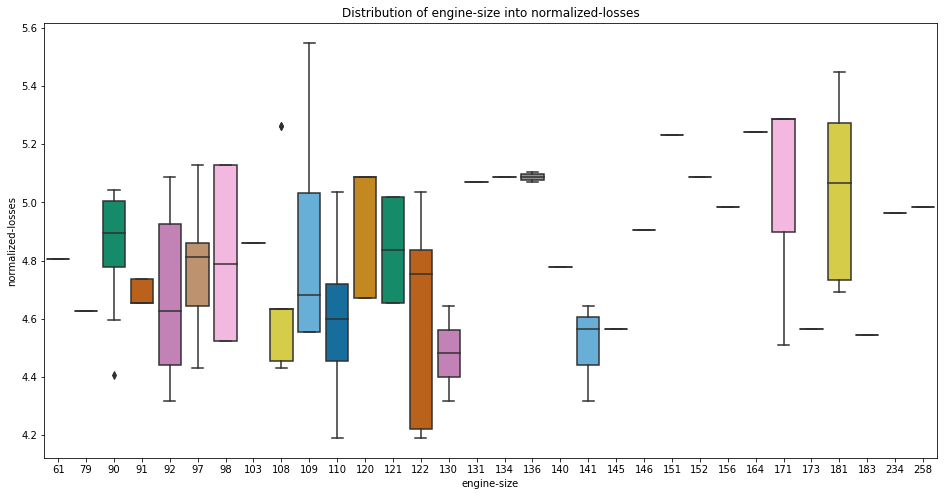

In [23]:
# Plotting Distribution of symboling into noemalized-losses
plt.figure(figsize=(16,8))
sns.boxplot(x='engine-size',y='normalized-losses',data=df, 
                 palette="colorblind")
plt.title('Distribution of engine-size into normalized-losses');

Here we can see that there is not a very clear pattern or relation between engine size and normalzied loss value. That is also the relation why correlation value was very low (0.19). Maybe some of the cars with large engine size indicate a little higher normalized-loss but still the trend is not very consistent. Therefore, it is not a very useful feature.

#  Training

# # Data preparation

In [24]:
# Conveting categorical data to numerical

df = pd.get_dummies(df)
df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,...,price_9495,price_9538,price_9549,price_9639,price_9959,price_9960,price_9980,price_9988,price_9989,price_9995
3,2,5.105945,99.8,176.6,66.2,54.3,2337,109,10.0,24,...,0,0,0,0,0,0,0,0,0,0
4,2,5.105945,99.4,176.6,66.4,54.3,2824,136,8.0,18,...,0,0,0,0,0,0,0,0,0,0
6,1,5.068904,105.8,192.7,71.4,55.7,2844,136,8.5,19,...,0,0,0,0,0,0,0,0,0,0
8,1,5.068904,105.8,192.7,71.4,55.9,3086,131,8.3,17,...,0,0,0,0,0,0,0,0,0,0
10,2,5.262690,101.2,176.8,64.8,54.3,2395,108,8.8,23,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# splitting the data with our target into y1 and the rest of data into x1
x = df.drop(['ID', 'normalized-losses'], axis=1)
y = df['normalized-losses']

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) 
# 80% train and 20% test

In [27]:
x_train.shape, y_train.shape

((127, 336), (127,))

In [28]:
x_test.shape, y_test.shape

((32, 336), (32,))

# # Model Selection

In [29]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

In [30]:
import xgboost as XGB

#1st model
model = XGB.XGBRegressor()
model.fit(x_train, y_train, verbose=True) # or x_train['symboling'] because it depends mostly on symboling

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
from sklearn.linear_model import LinearRegression

# 2nd model
model2 = LinearRegression()
model2.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
y_pred = np.floor(np.expm1(model.predict(x_test)))
y_pred

array([160.,  93., 135., 121., 123.,  86., 147., 161.,  84., 106., 143.,
       127., 148., 129.,  97.,  85., 134., 102., 133., 148.,  82., 145.,
       130.,  83., 145., 167., 146., 121., 103.,  91.,  64., 177.],
      dtype=float32)

In [33]:
y_pred2 = np.floor(np.expm1(model2.predict(x_test)))
y_pred2

array([161.,  87., 147., 119., 117.,  72., 145., 191.,  93., 110.,  52.,
        86., 170., 114.,  81., 108., 149.,  88.,  98., 195.,  81., 112.,
       170.,  88., 137., 151., 107., 115.,  78.,  79.,  72., 161.])

In [34]:
y_test = np.floor(np.expm1(y_test))

In [35]:
y_test.head()

108    160.0
201     94.0
169    134.0
85     125.0
135    103.0
Name: normalized-losses, dtype: float64

In [36]:
# model1 quality metrics in test dataset prediction
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 11.3125
Root Mean Squared Error: 24.131152065328337


In [37]:
# model2 quality metrics in test dataset prediction
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

Mean Absolute Error: 25.9375
Root Mean Squared Error: 35.58352849282937


XGB Regressor seems to perform better

In [ ]:
# sub = pd.DataFrame()
# sub['ID'] = test_id
# sub['normalized-error'] = y_pred
# sub.to_csv('mysubmission.csv',index=False)